# Social Network Analysis Project - International Trade Flows Dataset 

In [25]:
import math
import cpnet
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

THRESHOLD = 1.0
PRODUCT = "Coal"
DATASET_PATH = "DatasetWithCountries.xlsx"



### Reading and cleaning the dataset

In [2]:
df = pd.read_excel(DATASET_PATH)
df = df[df["Value (thousands USD)"] > THRESHOLD]
df['ContinentExporter'] = df['ContinentExporter'].fillna("NA")
df['ContinentImporter'] = df['ContinentImporter'].fillna("NA")

df.head()

,Exporter,Importer,Product,Value (thousands USD),ContinentExporter,ContinentImporter
2,ALB,CZE,Eng,3382.312,EU,EU
3,ALB,GRC,Eng,41847.186,EU,EU
4,ALB,ITA,Oil,13472.550,EU,EU
5,ALB,SRB,Coal,33.708,EU,EU
6,ALB,SRB,Eng,5223.920,EU,EU


In [3]:
print("Min value: ", df["Value (thousands USD)"].min())
print("Max value: ", df["Value (thousands USD)"].max())

Min value:  1.006
Max value:  45469956.717


## Analyze based on Product 

In [4]:
df_product = df[df["Product"] == PRODUCT]
df_product.head()

,Exporter,Importer,Product,Value (thousands USD),ContinentExporter,ContinentImporter
5,ALB,SRB,Coal,33.708,EU,EU
87,AZE,GEO,Coal,43.500,AS,AS
118,ARG,BRA,Coal,229.782,SA,SA
123,ARG,CHL,Coal,1022.578,SA,SA
130,ARG,PRY,Coal,56.766,SA,SA


### Find Nodes and Edges of the selected product

In [5]:
product_nodes = list(set(df_product["Exporter"].unique().tolist() + df_product["Importer"].unique().tolist()))

continent_mapping = {}
for (index, row) in df_product.iterrows():
    continent_mapping[row["Exporter"]] = row["ContinentExporter"]
    continent_mapping[row["Importer"]] = row["ContinentImporter"]

product_edges = [(row["Exporter"], row["Importer"], row["Value (thousands USD)"]) for (index, row) in df_product.iterrows()]


## Creating corresponding graph

In [6]:
G_product = nx.DiGraph()

G_product.add_nodes_from(product_nodes)
for node in G_product.nodes():
    G_product.nodes[node]["Continent"] = continent_mapping[node]

G_product.add_weighted_edges_from(product_edges)

inverse_weights = {}
for u, v, d in G_product.edges(data=True):
    inverse_weights[(u,v)] = math.log(d["weight"]+1)
    
nx.set_edge_attributes(G_product, inverse_weights, name="inverse_weights")


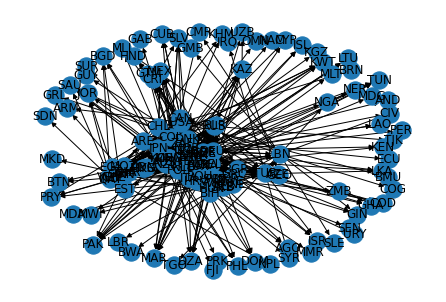

In [7]:
nx.draw(G_product, with_labels=True)

## Degree centrality

In [8]:
out_degree_centrality_list = sorted(nx.out_degree_centrality(G_product).items(), key=lambda item: item[1], reverse=True)
out_degree_centrality_list[:10]

[('CHN', 0.43478260869565216),
 ('POL', 0.37681159420289856),
 ('DEU', 0.32608695652173914),
 ('RUS', 0.2898550724637681),
 ('USA', 0.2463768115942029),
 ('ITA', 0.2391304347826087),
 ('COL', 0.2246376811594203),
 ('CZE', 0.2246376811594203),
 ('ESP', 0.21014492753623187),
 ('GBR', 0.18115942028985507)]

In [9]:
in_degree_centrality_list = sorted(nx.in_degree_centrality(G_product).items(), key=lambda item: item[1], reverse=True)
in_degree_centrality_list[:10]

[('IND', 0.18115942028985507),
 ('DEU', 0.13768115942028986),
 ('FRA', 0.13768115942028986),
 ('NLD', 0.13768115942028986),
 ('GBR', 0.13043478260869565),
 ('ESP', 0.12318840579710146),
 ('CHN', 0.11594202898550725),
 ('BEL', 0.11594202898550725),
 ('MYS', 0.10869565217391304),
 ('USA', 0.09420289855072464)]

## Strenght Centralities

In [16]:
# Custom function to calculate the strenght centrality
def strength_centrality(G, out=True): 
    strengths = dict()
    sum_of_weights = 0
    for node in G.nodes:
        strengths[node] = 0
    for u, v, d in G.edges(data=True):
        if not out:
            k = v
            v = u
            u = k
        strengths[u] += d["weight"]
        sum_of_weights += d["weight"]
    
    for key in strengths.keys():
        strengths[key] = strengths[key] / sum_of_weights
        
    return sorted(strengths.items(), key=lambda item: item[1], reverse=True)

### Out Strenght Centralities

In [17]:
out_strengths_centrality_list = strength_centrality(G_product, out=True)
out_strengths_centrality_list[:10]

[('POL', 0.25094190709138764),
 ('CHN', 0.14567359952310208),
 ('JPN', 0.11677536622331738),
 ('COL', 0.11658506686042935),
 ('RUS', 0.10397322368306111),
 ('DEU', 0.04570667004772723),
 ('USA', 0.033133994427504934),
 ('CZE', 0.02864557479418145),
 ('AUS', 0.023161629300708753),
 ('BIH', 0.016555099515807154)]

### In Strenght Centralities

In [18]:
in_strengths_centrality_list = strength_centrality(G_product, out=False)
in_degree_centrality_list[:10]

[('IND', 0.18115942028985507),
 ('DEU', 0.13768115942028986),
 ('FRA', 0.13768115942028986),
 ('NLD', 0.13768115942028986),
 ('GBR', 0.13043478260869565),
 ('ESP', 0.12318840579710146),
 ('CHN', 0.11594202898550725),
 ('BEL', 0.11594202898550725),
 ('MYS', 0.10869565217391304),
 ('USA', 0.09420289855072464)]

## Closeness centrality

In [20]:
closeness_centrality_list = sorted(nx.closeness_centrality(G_product, distance="inverse_weights").items(), key=lambda item: item[1], reverse=True)
closeness_centrality_list[:10]

[('NLD', 0.07139699802305303),
 ('SGP', 0.06682238574677327),
 ('TUR', 0.06389358855383666),
 ('CHE', 0.06231795756799982),
 ('BGR', 0.06209099601316599),
 ('CRI', 0.05955313841078842),
 ('IND', 0.05919489194857846),
 ('ROU', 0.058053546589702056),
 ('BGD', 0.056727425905378374),
 ('ISR', 0.05615977738130137)]

## Betweeness Centrality

In [21]:
betweeness_centrality_list = sorted(nx.betweenness_centrality(G_product, weight="inverse_weights").items(), key=lambda item: item[1], reverse=True)
betweeness_centrality_list[:10]

[('CHN', 0.10800803977573256),
 ('USA', 0.0804506505871152),
 ('DEU', 0.06923727917063366),
 ('NLD', 0.06786205437427272),
 ('IND', 0.0633661271554004),
 ('BEL', 0.05696604252618216),
 ('GBR', 0.0535808737966783),
 ('TUR', 0.050037025282978945),
 ('LBN', 0.04845022744102401),
 ('ESP', 0.047339468951655556)]

## Pagerank

In [22]:
pagerank_list = sorted(nx.pagerank(G_product, weight="weight").items(), key=lambda item: item[1], reverse=True)
pagerank_list[:10]

[('FRA', 0.04891677435275397),
 ('ITA', 0.0451570755800339),
 ('IND', 0.04083953287480624),
 ('BTN', 0.03215332279365746),
 ('CHN', 0.03159626204567659),
 ('ESP', 0.028786591256344352),
 ('GEO', 0.027212267453544853),
 ('AZE', 0.026299147067356022),
 ('IDN', 0.0251102368286571),
 ('DEU', 0.022233415235011763)]

## Assortative mixing

In [23]:
nx.attribute_assortativity_coefficient(G_product, attribute="Continent")

0.3533672612283214

## Assortativity by degree

In [24]:
nx.degree_assortativity_coefficient(G_product)

-0.10564216260298649

## Core-Periphery

In [26]:
algorithm = cpnet.LapCore()
algorithm.detect(G_product)

groups = algorithm.get_pair_id()
coreness = algorithm.get_coreness()

print("Groups")
#print([(c, groups[c]) for c in groups.keys() if groups[c]!=0])
print(groups)
print()
print("Coreness=1")
print([(c, coreness[c]) for c in coreness.keys() if coreness[c]==1])
print("Coreness=0")
print([(c, coreness[c]) for c in coreness.keys() if coreness[c]==0])

Groups
{'LVA': 0, 'IND': 0, 'DZA': 0, 'PHL': 0, 'HND': 0, 'HKG': 0, 'MNE': 0, 'QAT': 0, 'AZE': 0, 'SGP': 0, 'KWT': 0, 'ECU': 0, 'SYR': 0, 'PRY': 0, 'SAU': 0, 'GRC': 0, 'MKD': 0, 'CHL': 0, 'EGY': 0, 'CRI': 0, 'GUY': 0, 'GIN': 0, 'ARM': 0, 'FIN': 0, 'ROU': 0, 'NGA': 0, 'KHM': 0, 'CMR': 0, 'ESP': 0, 'PER': 0, 'BMU': 0, 'IDN': 0, 'RUS': 0, 'IRL': 0, 'COL': 0, 'LAO': 0, 'DNK': 0, 'BGD': 0, 'GTM': 0, 'DEU': 0, 'MDG': 0, 'LKA': 0, 'BRA': 0, 'BGR': 0, 'DOM': 0, 'GMB': 0, 'LBR': 0, 'IRQ': 0, 'MLT': 0, 'SUR': 0, 'OMN': 0, 'ZAF': 0, 'LTU': 0, 'SRB': 0, 'PRT': 0, 'AUS': 0, 'MWI': 0, 'VEN': 0, 'KOR': 0, 'NZL': 0, 'PAN': 0, 'BWA': 0, 'MAR': 0, 'USA': 0, 'MMR': 0, 'MLI': 0, 'MNG': 0, 'CZE': 0, 'BTN': 0, 'TUN': 0, 'CHN': 0, 'UKR': 0, 'JPN': 0, 'TGO': 0, 'SVN': 0, 'GAB': 0, 'FRA': 0, 'SEN': 0, 'SLV': 0, 'BIH': 0, 'GBR': 0, 'COD': 0, 'NAM': 0, 'ZMB': 0, 'BLR': 0, 'URY': 0, 'POL': 0, 'BEL': 0, 'HRV': 0, 'CAN': 0, 'ARG': 0, 'EST': 0, 'GHA': 0, 'ISL': 0, 'LBN': 0, 'AUT': 0, 'CUB': 0, 'MEX': 0, 'CYP': 0, 'A

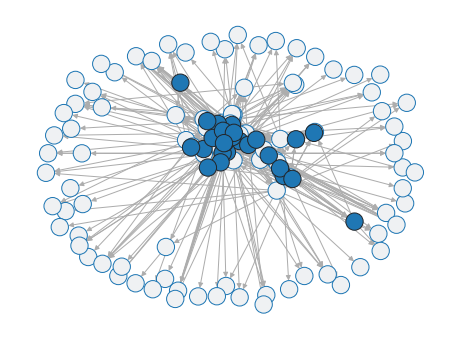

In [27]:
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()
ax, pos = cpnet.draw(G_product, groups, coreness, ax)

# New graph with total flow in USD 

In [28]:
df_total = df.groupby(['Exporter','Importer'])['Value (thousands USD)'].sum().reset_index()
df_total

,Exporter,Importer,Value (thousands USD)
0,ABW,KOR,7.491343e+04
1,AGO,BEL,2.296520e+02
2,AGO,BRA,3.059060e+04
3,AGO,CHL,6.786450e+04
4,AGO,CHN,1.260183e+07
...,...,...,...
1932,ZWE,MWI,3.417301e+03
1933,ZWE,NAM,5.086895e+03
1934,ZWE,SWZ,8.320575e+03
1935,ZWE,ZAF,9.598700e+03


In [29]:
totalUSD_nodes = list(set(df_total["Exporter"].unique().tolist() + df_total["Importer"].unique().tolist()))

totalUSD_edges = [(row["Exporter"], row["Importer"], row["Value (thousands USD)"]) for (index, row) in df_total.iterrows()]

## Create Total Graph

In [30]:
G_total = nx.DiGraph()
G_total.add_nodes_from(totalUSD_nodes)
G_total.add_weighted_edges_from(totalUSD_edges)

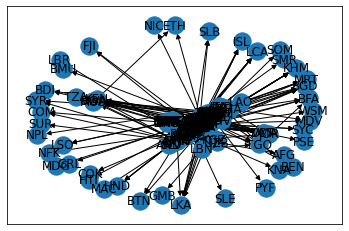

In [31]:
nx.draw_networkx(G_total,with_labels=True)

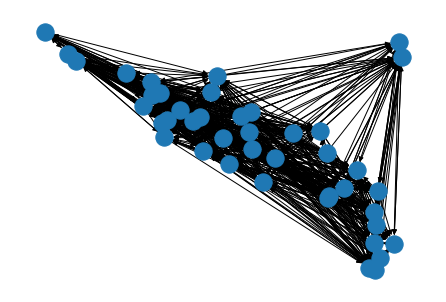

In [32]:
nx.draw(nx.k_core(G_total))

## Clustering coefficient for each node (local)

In [ ]:
sorted(nx.clustering(G_total).items(), key=lambda item: item[1], reverse=True)

## Average Clustering coefficient

In [ ]:
nx.average_clustering(G_total)

## Transitivity

In [ ]:
nx.transitivity(G_total)

## Reciprocity on the whole network

In [ ]:
nx.reciprocity(G_total)